In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import urllib.parse
from scipy.stats import linregress
from api_keys import omdb_api_key
from pprint import pprint
import scipy.stats as st

#print(omdb_api_key)

# Sets the path to our movie csv file
path = 'Resources/boxoffice.csv'

In [2]:
# Pulls in a list of ~16000 top movies of all time
top_boxoffice_df = pd.read_csv(path)

# Drops the maunally created index column
top_boxoffice_df.drop(labels=['index'], axis=1, inplace=True)

top_boxoffice_df

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: Episode VII,BV,936662225,2015
1,2,Avengers: Endgame,BV,857190335,2019
2,3,Avatar,Fox,760507625,2009
3,4,Black Panther,BV,700059566,2018
4,5,Avengers: Infinity War,BV,678815482,2018
...,...,...,...,...,...
16537,16538,Dog Eat Dog,IFC,80,2009
16538,16539,Paranoid Girls,NaN,78,2015
16539,16540,Confession of a Child of the Century,Cohen,74,2015
16540,16541,Storage 24,Magn.,72,2013


In [3]:
top1k_boxoffice_df = pd.read_csv(path, nrows = 1000)

# Drops the maunally created index column
top1k_boxoffice_df.drop(labels=['index'], axis=1, inplace=True)

top1k_boxoffice_df

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: Episode VII,BV,936662225,2015
1,2,Avengers: Endgame,BV,857190335,2019
2,3,Avatar,Fox,760507625,2009
3,4,Black Panther,BV,700059566,2018
4,5,Avengers: Infinity War,BV,678815482,2018
...,...,...,...,...,...
995,996,City of Angels,WB,78685114,1998
996,997,The English Patient,Mira.,78676425,1996
997,998,Teenage Mutant Ninja Turtles II,NL,78656813,1991
998,999,A.I. Artificial Intelligence,WB,78616689,2001


In [4]:
bot1k_boxoffice_df = pd.read_csv(path, skiprows= 15542, nrows = 1001, names=['rank', 'index', 'title', 'studio', 'lifetime_gross', 'year'])

# Drops the maunally created index column
bot1k_boxoffice_df.drop(labels=['index'], axis=1, inplace=True)

bot1k_boxoffice_df

,rank,title,studio,lifetime_gross,year
0,15541,December,IRS,5868,1991
1,15542,Buzzkill,Indic.,5860,2012
2,15543,Gaudi Afternoon,Cn4,5858,2003
3,15544,Top Spin,FRun,5858,2015
4,15545,The Work,Orch.,5853,2017
...,...,...,...,...,...
996,16537,Dog Eat Dog,IFC,80,2009
997,16538,Paranoid Girls,NaN,78,2015
998,16539,Confession of a Child of the Century,Cohen,74,2015
999,16540,Storage 24,Magn.,72,2013


In [5]:
# Creates a list of all of the movie titles in the top 1k movies from the dataframe
movies_list = top1k_boxoffice_df['title'].tolist()

# Creates empty lists for all of the information we want from the json requests
req_imdbID = []
req_titles = []
req_studio = []
req_boxoffice = []
req_runtime = []
req_age_rating = []
req_release_date = []
req_country = []
req_genre = []
req_imdb_rating = []
req_imdb_votecount = []
req_critic_rating = []
req_directors = []

print('Beginning OMDb data retriveal:')
print('______________________________')

try:
    
    # Loops through the dataframe and pulls the rest of  the information for the movies from OMDb API
    for movie_title in movies_list:

        # Encodes the entire movie title to account for characters
        encoded_title = urllib.parse.quote(movie_title)

        # Sets the base url for OMDb API and prints it out, comment out the printing function if using in public
        omdb_url = f'http://www.omdbapi.com/?t={encoded_title}&apikey={omdb_api_key}'
        print(f"API Request URL: {omdb_url}")

        # Creates a request to the OMDb API
        response = requests.get(omdb_url)
        request = response.json()

        # Tells us what is wrong with a request if it is not good
        if response.status_code != 200 or request['Response'] == 'False':
            print(f"Failed to retrieve movie '{movie_title}' from OMDb API.")
            print(f"Response: {request}")
            continue

        # Skips tv series from the data set
        if request['Type'] == 'series':
            print(f"'{movie_title}' is a TV series. Skipping...")
            continue

        # Gets the studio of each movie when it loops through the list
        studio_info = top1k_boxoffice_df.loc[top1k_boxoffice_df['title'] == movie_title, 'studio'].values[0]

        # Adds the information of each title to each list
        req_imdbID.append(request['imdbID'])
        req_titles.append(request['Title'])
        req_studio.append(studio_info)
        req_boxoffice.append(request['BoxOffice'])
        req_runtime.append(request['Runtime'])
        req_age_rating.append(request['Rated'])
        req_release_date.append(request['Released'])
        req_country.append(request['Country'])
        req_genre.append(request['Genre'])
        req_imdb_rating.append(request['imdbRating'])
        req_imdb_votecount.append(request['imdbVotes'])
        req_critic_rating.append(request['Metascore'])
        req_directors.append(request['Director'])

# Prints any errors that occured
except Exception as e:    
    print('An error occurred:', str(e))

print('______________________________')
print('Data retrieval complete')

    

Beginning OMDb data retriveal:
______________________________
API Request URL: http://www.omdbapi.com/?t=Star%20Wars%3A%20Episode%20VII&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Avengers%3A%20Endgame&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Avatar&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Black%20Panther&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Avengers%3A%20Infinity%20War&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Titanic&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Jurassic%20World&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Avengers&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Star%20Wars%3A%20The%20Last%20Jedi&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Incredibles%202&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Dark%20Knight&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Rogue%20One%3A%20A%20Star%20Wa

API Request URL: http://www.omdbapi.com/?t=The%20Empire%20Strikes%20Back&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Harry%20Potter%20and%20the%20Goblet%20of%20Fire&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Monsters%2C%20Inc.&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Home%20Alone&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Hunger%20Games%3A%20Mockingjay%20-%20Part%202&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Matrix%20Reloaded&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Twilight%20Saga%3A%20Breaking%20Dawn%20Part%201&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Meet%20the%20Fockers&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Hangover&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Gravity&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Dr.%20Seuss%27%20The%20Grinch&apikey=c5561cf2
API Request URL: http://www.omdbapi.c

API Request URL: http://www.omdbapi.com/?t=Sherlock%20Holmes&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Dawn%20of%20the%20Planet%20of%20the%20Apes&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Batman%20Begins&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Charlie%20and%20the%20Chocolate%20Factory&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Ratatouille&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Thor%3A%20The%20Dark%20World&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Austin%20Powers%3A%20The%20Spy%20Who%20Shagged%20Me&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Terminator%202%3A%20Judgment%20Day&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Amazing%20Spider-Man%202&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=World%20War%20Z&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Mummy%20Returns&apikey=c5561cf2
API Request URL: http://www.omdbapi

API Request URL: http://www.omdbapi.com/?t=Hidden%20Figures&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Bridesmaids&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Quantum%20of%20Solace&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Wild%20Hogs&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Kong%3A%20Skull%20Island&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Three%20Men%20and%20a%20Baby&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Gone%20Girl&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Hotel%20Transylvania%203%3A%20Summer%20Vacation&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Casino%20Royale&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Meet%20the%20Parents&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Fifty%20Shades%20of%20Grey&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=2012&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Rob

Failed to retrieve movie 'Marley and Me' from OMDb API.
Response: {'Response': 'False', 'Error': 'Movie not found!'}
API Request URL: http://www.omdbapi.com/?t=The%20Smurfs&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=XXX&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Jungle%20Book&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Chronicles%20of%20Narnia%3A%20Prince%20Caspian&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=National%20Lampoon%27s%20Animal%20House&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Pocahontas&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=A%20Few%20Good%20Men&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Slumdog%20Millionaire&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Rush%20Hour&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Blair%20Witch%20Project&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Deep%20Impact&apikey=c55

API Request URL: http://www.omdbapi.com/?t=Lucy&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Legend%20of%20Tarzan&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Bee%20Movie&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Prometheus&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Safe%20House&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Mr.%20Deeds&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Truman%20Show&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Erin%20Brockovich&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Ocean%27s%20Twelve&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Terminator%20Salvation&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Charlie%27s%20Angels&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Tomorrow%20Never%20Dies&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Lone%20Survivor&apikey=c5561cf2
API Request 

API Request URL: http://www.omdbapi.com/?t=Magic%20Mike&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Addams%20Family&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Patriot&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Bad%20Moms&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Bourne%20Legacy&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Pacifier&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Dr.%20Dolittle%202&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Rocky%20Horror%20Picture%20Show&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=It%27s%20Complicated&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Spy%20Kids&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Ghostbusters%20II&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Face/Off&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Hangover%20Part%20III&apikey=c

API Request URL: http://www.omdbapi.com/?t=The%20Maze%20Runner&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=In%20the%20Line%20of%20Fire&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Butch%20Cassidy%20and%20the%20Sundance%20Kid&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Mary%20Poppins&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Bambi&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Annabelle%3A%20Creation&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Equalizer%202&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Jackass%20Presents%3A%20Bad%20Grandpa&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Pacific%20Rim&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Journey%20to%20the%20Center%20of%20the%20Earth&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Gone%20in%2060%20Seconds&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Maverick&apikey=c5561cf2
A

API Request URL: http://www.omdbapi.com/?t=Elysium&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Flubber&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Flashdance&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=When%20Harry%20Met%20Sally...&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Town&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Non-Stop&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Client&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Blade%20Runner%202049&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=John%20Wick%3A%20Chapter%20Two&apikey=c5561cf2
Failed to retrieve movie 'John Wick: Chapter Two' from OMDb API.
Response: {'Response': 'False', 'Error': 'Movie not found!'}
API Request URL: http://www.omdbapi.com/?t=Star%20Trek%3A%20First%20Contact&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Think%20Like%20a%20Man&apikey=c5561cf2
API Request URL: http://ww

API Request URL: http://www.omdbapi.com/?t=Paranormal%20Activity%202&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Steel%20Magnolias&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Poseidon%20Adventure&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Tammy&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20Santa%20Clause%203%3A%20The%20Escape%20Clause&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Ferdinand&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Crazy%2C%20Stupid%2C%20Love.&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Annabelle&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Pinocchio&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Scooby-Doo%202%3A%20Monsters%20Unleashed&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Atlantis%3A%20The%20Lost%20Empire&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Cliffhanger&apikey=c5561cf2
API Request URL: 

API Request URL: http://www.omdbapi.com/?t=Pixels&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=City%20of%20Angels&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=The%20English%20Patient&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Teenage%20Mutant%20Ninja%20Turtles%20II&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=A.I.%20Artificial%20Intelligence&apikey=c5561cf2
API Request URL: http://www.omdbapi.com/?t=Cocktail&apikey=c5561cf2
______________________________
Data retrieval complete


In [6]:
# Creates our usable dataframe for our movies
total_movie_df = pd.DataFrame({
    'IMDb ID': req_imdbID,
    'Movie Title': req_titles,
    'Studio': req_studio,
    'Box Office Sales': req_boxoffice,
    'Movie Runtime': req_runtime,
    'Age Rating': req_age_rating,
    'Release Date' : req_release_date,
    'Country' : req_country,
    'Genre': req_genre,
    'IMDb Rating' : req_imdb_rating,
    'IMDb Vote Count' : req_imdb_votecount,
    'Critic Rating' : req_critic_rating,
    'Director(s)' : req_directors,
})


total_movie_df

,IMDb ID,Movie Title,Studio,Box Office Sales,Movie Runtime,Age Rating,Release Date,Country,Genre,IMDb Rating,IMDb Vote Count,Critic Rating,Director(s)
0,tt2488496,Star Wars: Episode VII - The Force Awakens,BV,"$936,662,225",138 min,PG-13,18 Dec 2015,United States,"Action, Adventure, Sci-Fi",7.8,"945,099",80,J.J. Abrams
1,tt4154796,Avengers: Endgame,BV,"$858,373,000",181 min,PG-13,26 Apr 2019,United States,"Action, Adventure, Drama",8.4,"1,172,062",78,"Anthony Russo, Joe Russo"
2,tt0499549,Avatar,Fox,"$785,221,649",162 min,PG-13,18 Dec 2009,United States,"Action, Adventure, Fantasy",7.9,"1,338,789",83,James Cameron
3,tt1825683,Black Panther,BV,"$700,426,566",134 min,PG-13,16 Feb 2018,United States,"Action, Adventure, Sci-Fi",7.3,"798,824",88,Ryan Coogler
4,tt4154756,Avengers: Infinity War,BV,"$678,815,482",149 min,PG-13,27 Apr 2018,United States,"Action, Adventure, Sci-Fi",8.4,"1,116,082",68,"Anthony Russo, Joe Russo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,tt0120632,City of Angels,WB,"$78,685,114",114 min,PG-13,10 Apr 1998,"United States, Germany","Drama, Fantasy, Romance",6.7,"123,806",54,Brad Silberling
968,tt0116209,The English Patient,Mira.,"$78,676,425",162 min,R,06 Dec 1996,"United States, United Kingdom","Drama, Romance, War",7.4,"194,715",87,Anthony Minghella
969,tt0103060,Teenage Mutant Ninja Turtles II: The Secret of...,NL,"$78,656,813",88 min,PG,22 Mar 1991,"Hong Kong, United States","Action, Adventure, Comedy",6.0,"57,832",45,Michael Pressman
970,tt0212720,A.I. Artificial Intelligence,WB,"$78,616,689",146 min,PG-13,29 Jun 2001,"United States, United Kingdom","Drama, Sci-Fi",7.2,"314,145",65,Steven Spielberg


The correlation coefficient between movie runtime and box office sales is 0.26


Text(0.5, 1.0, 'Movie Runtime vs. Box Office Sales')

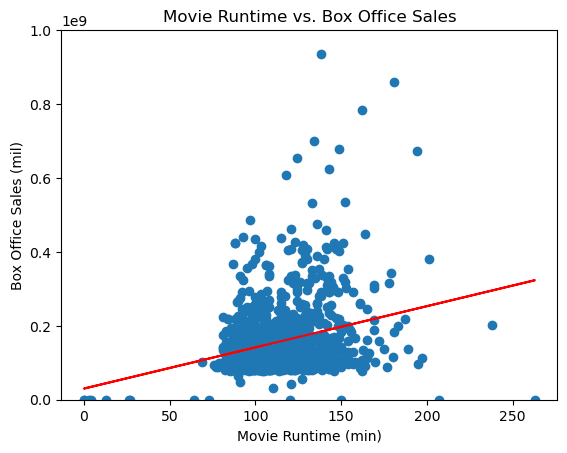

In [8]:
#runtime vs box office (scatter)
#set runtime and box office to Series
#clean total_movie_df to better fit upcoming variables
total_movie_df['Movie Runtime'] = total_movie_df['Movie Runtime'].str.replace(' min','').str.replace('N/A','0').astype(float)
total_movie_df['Box Office Sales'] = total_movie_df['Box Office Sales'].str.replace('$','').str.replace(',','').str.replace('N/A','0').astype(float)

runtime = total_movie_df['Movie Runtime']
box_office = total_movie_df['Box Office Sales']

#make scatter plot, find corr. coe. and line regress)
print(f"The correlation coefficient between movie runtime and box office sales is {round(st.pearsonr(runtime,box_office)[0],2)}")
m_slope, m_int, m_r, m_p, m_std_err = st.linregress(runtime, box_office)
m_fit = m_slope * runtime + m_int
plt.scatter(runtime, box_office)
plt.plot(runtime,m_fit,"-",color='red')
plt.ylim(0, 1000000000)
plt.xlabel('Movie Runtime (min)')
plt.ylabel('Box Office Sales (mil)')
plt.title('Movie Runtime vs. Box Office Sales')

#there is a weak positive correlation between movie runtime and how well they do in the box office. 

In [9]:
#genre vs box office (bar)
# genre = total_movie_df['Genre'].str.split(',').str[0]
# plt.bar(genre,box_office,align='center')
# plt.xticks(rotation=45)
# plt.xlabel('Genre')
# plt.ylabel('Box Office Sales (mil)')
# plt.title

total_movie_df['Box Office Sales'] = total_movie_df['Box Office Sales'].astype(str).str.replace('$','').str.replace(',','').str.replace('N/A','0').astype(float)
total_movie_df['Genre'] = total_movie_df['Genre'].str.split(',').str[0]
genre_boxoffice = total_movie_df.groupby('Genre')['Box Office Sales'].mean()
genre = genre_boxoffice.index

# plt.bar(genre,genre_boxoffice,align='center')
# plt.xticks(rotation=90)
# plt.xlabel('Genre')
# plt.ylabel('Average Box Office Sales (mil)')
# plt.title('Average Box Office Sales of Each Genre')

genre_boxoffice

Genre
Action         1.834870e+08
Adventure      1.751948e+08
Animation      1.833400e+08
Biography      1.260609e+08
Comedy         1.216500e+08
Crime          1.107687e+08
Documentary    3.973159e+07
Drama          1.383349e+08
Family         0.000000e+00
Fantasy        1.378721e+08
Horror         1.195091e+08
Mystery        1.439508e+08
N/A            0.000000e+00
Sci-Fi         7.924946e+07
Short          0.000000e+00
Name: Box Office Sales, dtype: float64